# Processing Our Data - 1

In [2]:
from astropy.io import fits
import pandas as pd
import numpy as np
import os
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from tqdm import tqdm
import requests
from scipy.interpolate import interp1d
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import ast
from threading import Lock
import hashlib
import umap.umap_ as umap

In [4]:
accessed_star_database = fits.open("../data/specObj-dr17.fits")

In [5]:
accessed_star_database.info()

Filename: ../data/specObj-dr17.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    283   5801200R x 133C   [6A, 4A, 16A, 27A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 20A, I, 4A, 7A, 7A, J, D, D, D, E, E, 25A, 8A, K, J, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, 6A, 21A, E, E, J, J, A, 5E, 5E]   


In [6]:
binary_table = accessed_star_database[1].data
print(binary_table.columns.names)

['SURVEY', 'INSTRUMENT', 'CHUNK', 'PROGRAMNAME', 'PLATERUN', 'PLATEQUALITY', 'PLATESN2', 'DEREDSN2', 'LAMBDA_EFF', 'BLUEFIBER', 'ZOFFSET', 'SNTURNOFF', 'NTURNOFF', 'SPECPRIMARY', 'SPECSDSS', 'SPECLEGACY', 'SPECSEGUE', 'SPECSEGUE1', 'SPECSEGUE2', 'SPECBOSS', 'BOSS_SPECOBJ_ID', 'SPECOBJID', 'FLUXOBJID', 'BESTOBJID', 'TARGETOBJID', 'PLATEID', 'NSPECOBS', 'FIRSTRELEASE', 'RUN2D', 'RUN1D', 'DESIGNID', 'CX', 'CY', 'CZ', 'XFOCAL', 'YFOCAL', 'SOURCETYPE', 'TARGETTYPE', 'THING_ID_TARGETING', 'THING_ID', 'PRIMTARGET', 'SECTARGET', 'LEGACY_TARGET1', 'LEGACY_TARGET2', 'SPECIAL_TARGET1', 'SPECIAL_TARGET2', 'SEGUE1_TARGET1', 'SEGUE1_TARGET2', 'SEGUE2_TARGET1', 'SEGUE2_TARGET2', 'MARVELS_TARGET1', 'MARVELS_TARGET2', 'BOSS_TARGET1', 'BOSS_TARGET2', 'EBOSS_TARGET0', 'EBOSS_TARGET1', 'EBOSS_TARGET2', 'EBOSS_TARGET_ID', 'ANCILLARY_TARGET1', 'ANCILLARY_TARGET2', 'SPECTROGRAPHID', 'PLATE', 'TILE', 'MJD', 'FIBERID', 'OBJID', 'PLUG_RA', 'PLUG_DEC', 'CLASS', 'SUBCLASS', 'Z', 'Z_ERR', 'RCHI2', 'DOF', 'RCHI2DIF

In [7]:
space_dataframe = pd.DataFrame(binary_table[:4000000].tolist(), columns=binary_table.columns.names)
pd.set_option('display.max_columns', None)
space_dataframe.head()

,SURVEY,INSTRUMENT,CHUNK,PROGRAMNAME,PLATERUN,PLATEQUALITY,PLATESN2,DEREDSN2,LAMBDA_EFF,BLUEFIBER,ZOFFSET,SNTURNOFF,NTURNOFF,SPECPRIMARY,SPECSDSS,SPECLEGACY,SPECSEGUE,SPECSEGUE1,SPECSEGUE2,SPECBOSS,BOSS_SPECOBJ_ID,SPECOBJID,FLUXOBJID,BESTOBJID,TARGETOBJID,PLATEID,NSPECOBS,FIRSTRELEASE,RUN2D,RUN1D,DESIGNID,CX,CY,CZ,XFOCAL,YFOCAL,SOURCETYPE,TARGETTYPE,THING_ID_TARGETING,THING_ID,PRIMTARGET,SECTARGET,LEGACY_TARGET1,LEGACY_TARGET2,SPECIAL_TARGET1,SPECIAL_TARGET2,SEGUE1_TARGET1,SEGUE1_TARGET2,SEGUE2_TARGET1,SEGUE2_TARGET2,MARVELS_TARGET1,MARVELS_TARGET2,BOSS_TARGET1,BOSS_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,EBOSS_TARGET_ID,ANCILLARY_TARGET1,ANCILLARY_TARGET2,SPECTROGRAPHID,PLATE,TILE,MJD,FIBERID,OBJID,PLUG_RA,PLUG_DEC,CLASS,SUBCLASS,Z,Z_ERR,RCHI2,DOF,RCHI2DIFF,TFILE,TCOLUMN,NPOLY,THETA,VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,WAVEMIN,WAVEMAX,WCOVERAGE,ZWARNING,SN_MEDIAN_ALL,SN_MEDIAN,CHI68P,FRACNSIGMA,FRACNSIGHI,FRACNSIGLO,SPECTROFLUX,SPECTROFLUX_IVAR,SPECTROSYNFLUX,SPECTROSYNFLUX_IVAR,SPECTROSKYFLUX,ANYANDMASK,ANYORMASK,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I,ELODIE_FILENAME,ELODIE_OBJECT,ELODIE_SPTYPE,ELODIE_BV,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,ELODIE_Z,ELODIE_Z_ERR,ELODIE_Z_MODELERR,ELODIE_RCHI2,ELODIE_DOF,Z_NOQSO,Z_ERR_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,RCHI2DIFF_NOQSO,Z_PERSON,CLASS_PERSON,Z_CONF_PERSON,COMMENTS_PERSON,CALIBFLUX,CALIBFLUX_IVAR
0,sdss,SDSS,chunk4,legacy,chunk4,bad,7.67533,0.0,5000.0,-1,0.0,-9999.0,-1,0,0,0,0,0,0,0,0,299489676975171584,1237648720142401611,1237648720142401611,284722522357889,299489402097264640,2,dr7,26,,-1,-0.835805,0.548725,-0.018173,179.036087,-240.321457,GALAXY,SCIENCE,0,0,96,0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,266,122,51602,1,"[756, 1, 1, 206, 129]",146.71421,-1.041304,GALAXY,,0.021275,0.000009,1.074070,3770,3.873685,spEigenGal-53724.fits,"[0, 1, 2, 3, -1, -1, -1, -1, -1, -1]",3,"[0.010862293653190136, -0.0225241519510746, -0...",135.899567,4.085766,0.0,0.0,1677.303467,2168.0,2117,3806.273682,9202.376953,0.3777,0,38.055374,"[5.470128536224365, 30.580841064453125, 45.513...",0.961614,"[0.30076780915260315, 0.056129202246665955, 0....","[0.15064866840839386, 0.02621127851307392, 0.0...","[0.1501191407442093, 0.029917923733592033, 0.0...","[47.65951919555664, 140.48928833007812, 325.88...","[1.3083244562149048, 3.5849850177764893, 2.237...","[39.69293975830078, 140.70152282714844, 326.07...","[2.9729716777801514, 3.7280795574188232, 2.342...","[9.833003044128418, 15.357330322265625, 37.866...",230752256,266272768,20.858,16.172701,13.4718,13.3075,10.6615,7.67533,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,,,0.0,0.0,0,0,,"[30.75096321105957, 141.45950317382812, 329.55...","[3.9342143535614014, 5.019459247589111, 2.6404..."
1,sdss,SDSS,chunk4,legacy,chunk4,bad,7.67533,0.0,5000.0,-1,0.0,-9999.0,-1,0,0,0,0,0,0,0,0,299489951853078528,1237648720142532891,1237648720142532891,284722522489067,299489402097264640,2,dr7,26,,-1,-0.837779,0.545736,-0.017286,223.895264,-229.371475,GALAXY,SCIENCE,0,0,64,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,266,122,51602,2,"[756, 1, 1, 208, 235]",146.91945,-0.990492,GALAXY,,0.213925,0.000052,1.331336,3781,0.179131,spEigenGal-53724.fits,"[0, 1, 2, 3, -1, -1, -1, -1, -1, -1]",3,"[0.0010820967145264149, -0.0007276945398189127...",140.481186,15.037567,0.0,0.0,2411.130859,2168.0,2117,3806.273682,9202.376953,0.3788,0,6.404140,"[0.2876650393009186, 2.889864921569824, 8.0417...",1.128138,"[0.3732840418815613, 0.08236536383628845, 0.01...","[0.1906019002199173, 0.035902850329875946, 0.0...","[0.18268215656280518, 0.046462513506412506, 0....","[1.6532617807388306, 7.8250813484191895, 25.46...","[1.3083244562149048, 3.5849850177764893, 2.237...","[2.3984920978546143, 7.62562894821167, 26.0012...","[2.9729716777801514, 3.7280795574188232, 2.342...","[8.733312606811523, 14.05916976928711, 35.1544...",231800832,266272768,20.858,16.172701,13.4718,13.3075,10.6615,7.67533,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,,,0.0,0.0,

In [15]:
columns_to_keep = [
    'PLATE', 'MJD', 'FIBERID',
    'CLASS', 'SUBCLASS',
    'ELODIE_SPTYPE', 'ELODIE_TEFF', 'ELODIE_LOGG', 'ELODIE_FEH',
    'Z', 'Z_ERR', 'ZWARNING',
    'VDISP', 'VDISP_ERR',
    'SN_MEDIAN_ALL', 'RCHI2', 'DOF',
    'SPECTROFLUX'  
]
space_dataframe_clean = space_dataframe[columns_to_keep]
space_dataframe_clean.shape

(4000000, 18)

In [16]:
print(space_dataframe_clean['CLASS'].unique())

['GALAXY' 'QSO   ' 'STAR  ']


In [17]:
star_dataframe = space_dataframe_clean[space_dataframe_clean['CLASS'].str.strip() == 'STAR']
star_dataframe.shape

(947925, 18)

In [18]:
def clean_subclass(label):
    if pd.isnull(label):
        return None
    return re.sub(r'\s*\(.*\)', '', label).strip()

In [19]:
star_dataframe['SUBCLASS_CLEAN'] = star_dataframe['SUBCLASS'].apply(clean_subclass)
print(star_dataframe['SUBCLASS_CLEAN'].value_counts())

SUBCLASS_CLEAN
F9              129881
F5              107170
A0               70392
F3/F5V           58020
K3               35378
K5               35339
K1               34042
G2               32381
CV               21377
K7               20680
M1               20321
M2               18450
M3               17374
G0               17072
F2               16386
WD               15799
M0               14045
M5III            13450
F0IV             13119
M4               12096
F8V              10419
K3V              10196
T2               10061
M4.5:III          9833
M6                9331
A2II              9129
A4V               8760
WDcooler          8631
K5Ve              8476
M5                7264
G8V               7129
F2V               6242
L5.5              6002
WDhotter          5893
L9                5398
G4V               5165
K0V               4754
M6III             4524
WDmagnetic        4199
M7                3600
F0II              3495
F6V               3391
O                 3

C:\Users\radiant\AppData\Local\Temp\ipykernel_26252\3650917493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_dataframe['SUBCLASS_CLEAN'] = star_dataframe['SUBCLASS'].apply(clean_subclass)


In [20]:
counts = star_dataframe['SUBCLASS_CLEAN'].value_counts()
common_classes = counts[counts > 1000].index
filtered_star_dataframe = star_dataframe[star_dataframe['SUBCLASS_CLEAN'].isin(common_classes)]
counts_filtered = filtered_star_dataframe['SUBCLASS_CLEAN'].value_counts()
pd.set_option('display.max_rows', None)
print(counts_filtered)

SUBCLASS_CLEAN
F9              129881
F5              107170
A0               70392
F3/F5V           58020
K3               35378
K5               35339
K1               34042
G2               32381
CV               21377
K7               20680
M1               20321
M2               18450
M3               17374
G0               17072
F2               16386
WD               15799
M0               14045
M5III            13450
F0IV             13119
M4               12096
F8V              10419
K3V              10196
T2               10061
M4.5:III          9833
M6                9331
A2II              9129
A4V               8760
WDcooler          8631
K5Ve              8476
M5                7264
G8V               7129
F2V               6242
L5.5              6002
WDhotter          5893
L9                5398
G4V               5165
K0V               4754
M6III             4524
WDmagnetic        4199
M7                3600
F0II              3495
F6V               3391
O                 3

In [21]:
filtered_star_dataframe.to_csv("../data/preengineered_star_dataframe")

In [19]:
filtered_star_dataframe = pd.read_csv("../data/temp_processed.csv")

In [20]:
def make_url(row):
    plate = int(row['PLATE'])
    mjd = int(row['MJD'])
    fiberid = int(row['FIBERID'])
    return f"https://data.sdss.org/sas/dr17/eboss/spectro/redux/v5_13_2/spectra/full/{plate}/spec-{plate}-{mjd}-{fiberid:04d}.fits"

In [21]:
filtered_star_dataframe['url'] = filtered_star_dataframe.apply(make_url, axis=1)

In [22]:
representative_dataframe = filtered_star_dataframe.copy()

target_total = 100_000
subclass_counts = representative_dataframe['SUBCLASS_CLEAN'].value_counts()
subclass_proportions = subclass_counts / subclass_counts.sum()

subclass_target_sizes = (subclass_proportions * target_total).astype(int)

sampled_df = pd.concat([
    representative_dataframe[representative_dataframe['SUBCLASS_CLEAN'] == subclass].sample(
        n=min(target_n, len(representative_dataframe[representative_dataframe['SUBCLASS_CLEAN'] == subclass])),
        random_state=42
    )
    for subclass, target_n in subclass_target_sizes.items()
])

sampled_df = sampled_df.reset_index(drop=True)

print(f"Final sample size: {len(sampled_df)}")

Final sample size: 99963


In [23]:
counts_filtered = sampled_df['SUBCLASS_CLEAN'].value_counts()
counts_filtered

SUBCLASS_CLEAN
F9        14094
F5        11629
A0         7638
F3/F5V     6296
K3         3839
          ...  
M2V         138
O8/O9       131
F2III       129
B6          127
sdF3        115
Name: count, Length: 75, dtype: int64

In [24]:
sampled_df.head()

,Unnamed: 0,PLATE,MJD,FIBERID,CLASS,SUBCLASS,ELODIE_SPTYPE,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,...,Z_ERR,ZWARNING,VDISP,VDISP_ERR,SN_MEDIAN_ALL,RCHI2,DOF,SPECTROFLUX,SUBCLASS_CLEAN,url
0,1840953,3466,54998,314,STAR,F9,G1V,5630.0,4.50,-0.45,...,0.000008,0,0.0,0.0,46.439968,1.150307,3680,"[56.01532745361328, 159.52830505371094, 258.28...",F9,https://data.sdss.org/sas/dr17/eboss/spectro/r...
1,1160913,2060,53706,594,STAR,F9,G8IV-V,5563.0,4.23,-0.02,...,0.000010,0,0.0,0.0,26.838177,1.252383,3714,"[8.48062801361084, 27.480884552001953, 50.9160...",F9,https://data.sdss.org/sas/dr17/eboss/spectro/r...
2,1665175,2938,54526,536,STAR,F9,G8IV-V,5563.0,4.23,-0.02,...,0.000009,0,0.0,0.0,60.171108,2.912636,3197,"[43.02244186401367, 123.2289810180664, 204.893...",F9,https://data.sdss.org/sas/dr17/eboss/spectro/r...
3,1810930,3308,54919,371,STAR,F9,G1V,5630.0,4.50,-0.45,...,0.000008,0,0.0,0.0,66.076248,1.536676,3629,"[90.08356475830078, 207.1901092529297, 319.572...",F9,https://data.sdss.org/sas/dr17/eboss/spectro/r...
4,1760881,3209,54906,242,STAR,F9,G5,5426.0,4.50,-0.04,...,0.000009,0,0.0,0.0,32.265663,1.224204,3512,"[16.109405517578125, 45.38063049316406, 74.009...",F9,https://data.sdss.org/sas/dr17/eboss/spectro/r...


In [25]:
sampled_df['url'].to_csv("urls_100k_proportional.txt", index=False, header=False)

In [13]:
sampled = sampled_df.copy()

sampled['url'] = sampled.apply(
    lambda row: f"https://data.sdss.org/sas/dr17/eboss/spectro/redux/v5_13_2/spectra/full/{int(row['PLATE'])}/spec-{int(row['PLATE'])}-{int(row['MJD'])}-{int(row['FIBERID']):04d}.fits",
    axis=1
)

def check_url(row):
    try:
        r = requests.head(row['url'], timeout=5)
        if r.status_code == 200:
            return row
    except:
        pass
    return None

valid_rows = []
counter = 0
valid_count = 0

with ThreadPoolExecutor(max_workers=64) as executor:
    futures = [executor.submit(check_url, row) for _, row in sampled.iterrows()]
    progress = tqdm(as_completed(futures), total=len(futures))

    for f in progress:
        result = f.result()
        counter += 1
        if result is not None:
            valid_rows.append(result)
            valid_count += 1

        if counter % 5000 == 0:
            print(f"Checked {counter} URLs —  {valid_count} valid so far")
        
        progress.set_postfix(valid=valid_count, checked=counter)

valid_df = pd.DataFrame(valid_rows)
print(f"Finished. Total valid spectra: {len(valid_df)}")

valid_df.to_csv("../data/sampled_metadata_valid.csv", index=False)
valid_df['url'].to_csv("../data/urls_100k_valid.txt", index=False, header=False)


  5%|▋            | 5040/99963 [01:31<08:37, 183.50it/s, checked=5040, valid=0]

Checked 5000 URLs —  0 valid so far


 10%|█▏          | 10026/99963 [03:29<09:37, 155.82it/s, checked=1e+4, valid=0]

Checked 10000 URLs —  0 valid so far


 15%|█▋         | 15029/99963 [04:40<06:13, 227.54it/s, checked=15038, valid=0]

Checked 15000 URLs —  0 valid so far


 20%|██▍         | 20039/99963 [06:40<05:28, 243.18it/s, checked=2e+4, valid=0]

Checked 20000 URLs —  0 valid so far


 25%|██▊        | 25011/99963 [08:37<04:46, 261.25it/s, checked=25027, valid=0]

Checked 25000 URLs —  0 valid so far


 30%|███▉         | 30015/99963 [10:37<13:14, 88.01it/s, checked=3e+4, valid=1]

Checked 30000 URLs —  1 valid so far


 35%|███▏     | 35002/99963 [12:36<51:10, 21.16it/s, checked=35002, valid=1374]

Checked 35000 URLs —  1373 valid so far


 40%|████      | 40011/99963 [14:42<10:04, 99.22it/s, checked=4e+4, valid=5714]

Checked 40000 URLs —  5714 valid so far


 45%|████     | 45004/99963 [16:20<28:56, 31.64it/s, checked=45004, valid=5889]

Checked 45000 URLs —  5888 valid so far


 50%|████▌    | 50008/99963 [17:53<03:51, 215.49it/s, checked=5e+4, valid=6179]

Checked 50000 URLs —  6179 valid so far


 55%|████▉    | 55016/99963 [20:00<09:04, 82.52it/s, checked=55023, valid=6560]

Checked 55000 URLs —  6544 valid so far


 60%|█████▍   | 60019/99963 [21:55<05:19, 124.85it/s, checked=6e+4, valid=7856]

Checked 60000 URLs —  7840 valid so far


 65%|█████▊   | 65005/99963 [23:25<17:22, 33.53it/s, checked=65013, valid=8300]

Checked 65000 URLs —  8300 valid so far


 70%|██████▎  | 70034/99963 [25:08<02:24, 207.32it/s, checked=7e+4, valid=8700]

Checked 70000 URLs —  8700 valid so far


 75%|█████▎ | 75050/99963 [27:18<01:53, 219.34it/s, checked=75053, valid=11094]

Checked 75000 URLs —  11094 valid so far


 80%|██████▍ | 80022/99963 [29:11<02:50, 116.71it/s, checked=8e+4, valid=13652]

Checked 80000 URLs —  13624 valid so far


 85%|█████▉ | 85021/99963 [31:17<02:24, 103.71it/s, checked=85025, valid=17198]

Checked 85000 URLs —  17173 valid so far


 90%|████████ | 90008/99963 [33:13<01:40, 99.00it/s, checked=9e+4, valid=19557]

Checked 90000 URLs —  19543 valid so far


 95%|███████▌| 95003/99963 [35:03<03:49, 21.65it/s, checked=95003, valid=22469]

Checked 95000 URLs —  22467 valid so far


100%|█████████| 99963/99963 [36:55<00:00, 45.11it/s, checked=1e+5, valid=24889]


Finished. Total valid spectra: 24889


In [ ]:
sampled = sampled_df.copy()


existing_valid_df = pd.read_csv("../data/sampled_metadata_valid.csv")  
valid_counts = existing_valid_df['SUBCLASS_CLEAN'].value_counts().to_dict() if 'sampled_metadata_valid.csv' in locals() else {}

TARGET = 300
valid_rows = []

def check_url(row):
    try:
        r = requests.head(row['url'], timeout=5)
        if r.status_code == 200:
            return row
    except:
        pass
    return None

underrepresented = sampled['SUBCLASS_CLEAN'].value_counts()
underrepresented = underrepresented[underrepresented < TARGET]

for subclass, current_count in underrepresented.items():
    print(f"\nProcessing subclass: {subclass} (currently {current_count})")
    needed = TARGET - valid_counts.get(subclass, 0)

    candidates = sampled[sampled['SUBCLASS_CLEAN'] == subclass]

    if len(candidates) == 0 or needed <= 0:
        continue

    candidates = candidates.sample(frac=1, random_state=42)

    checked = 0
    collected = 0
    with ThreadPoolExecutor(max_workers=64) as executor:
        futures = {executor.submit(check_url, row): row for _, row in candidates.iterrows()}
        for f in tqdm(as_completed(futures), total=len(futures), desc=f"{subclass}"):
            result = f.result()
            checked += 1
            if result is not None:
                valid_rows.append(result)
                collected += 1
                if collected >= needed:
                    break
            if checked % 100 == 0:
                tqdm.write(f"Checked {checked} — Collected {collected}/{needed}")

    print(f"{subclass}: Collected {collected} new valid samples")

final_valid_df = pd.DataFrame(valid_rows)
print(f"\n Finished collecting. Total new valid samples: {len(final_valid_df)}")

final_valid_df.to_csv("../data/sampled_metadata_valid_min300.csv", index=False)
final_valid_df['url'].to_csv("../data/urls_valid_min300.txt", index=False, header=False)

In [31]:
counts_final = final_valid_df['SUBCLASS_CLEAN'].value_counts()
pd.set_option('display.max_rows', None)
counts_final

SUBCLASS_CLEAN
F0V          293
Ldwarf       272
F0III        256
A8V          239
B5           236
A1V          223
A1III        215
CalciumWD    201
K0IV         191
G1V          174
sd:F0        158
O8/O9        131
F2III        129
Carbon        83
A5II          75
F0Ib          53
B9            43
sdF3          30
Name: count, dtype: int64

In [3]:
final_dataframe = pd.read_csv("../data/preengineered_star_dataframe")
pd.set_option('display.max_columns', None)

final_dataframe.head()

,Unnamed: 0,PLATE,MJD,FIBERID,CLASS,SUBCLASS,ELODIE_SPTYPE,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,Z,Z_ERR,ZWARNING,VDISP,VDISP_ERR,SN_MEDIAN_ALL,RCHI2,DOF,SPECTROFLUX,SUBCLASS_CLEAN
0,13,266,51602,14,STAR,A0,unknown,8500.0,4.000,-1.00,0.000661,0.000023,0,0.0,0.0,17.131834,1.331448,3769,"[37.20038986206055, 60.67053985595703, 65.8010...",A0
1,21,266,51602,22,STAR,WD,A0,7652.0,4.287,0.06,-0.000203,0.000017,0,0.0,0.0,35.487301,1.592232,3763,"[142.7136993408203, 225.40838623046875, 214.41...",WD
2,27,266,51602,28,STAR,F2,F9V,6038.0,4.370,-0.08,-0.000031,0.000008,0,0.0,0.0,35.359707,1.594363,3750,"[172.6872100830078, 247.32498168945312, 262.17...",F2
3,28,266,51602,29,STAR,WD,unknown,9000.0,4.000,-2.50,0.000603,0.000177,0,0.0,0.0,2.225974,1.139563,3742,"[3.5773072242736816, 6.811224460601807, 5.1800...",WD
4,30,266,51602,31,STAR,WD,unknown,9000.0,4.000,-2.50,-0.000037,0.000088,0,0.0,0.0,7.260117,1.147462,3771,"[15.293793678283691, 24.86993980407715, 22.676...",WD


In [4]:
keep_cols = ["ELODIE_TEFF",	"ELODIE_LOGG",	"ELODIE_FEH", "Z", "Z_ERR", "ZWARNING",	"VDISP", "VDISP_ERR",
             "SN_MEDIAN_ALL", "RCHI2", "DOF", "SNR_Bin", "High_Quality", "Mean_Flux", "Flux_to_Noise", "SPECTROFLUX"]

In [5]:
print(sorted(final_dataframe["SUBCLASS_CLEAN"].unique()))

['A0', 'A0p', 'A1III', 'A1V', 'A2II', 'A4V', 'A5II', 'A8V', 'A9V', 'B5', 'B6', 'B9', 'CV', 'CalciumWD', 'Carbon', 'CarbonWD', 'Carbon_lines', 'F0II', 'F0III', 'F0IV', 'F0Ib', 'F0V', 'F2', 'F2III', 'F2V', 'F3/F5V', 'F5', 'F6V', 'F8V', 'F9', 'G0', 'G0Va', 'G1V', 'G2', 'G4V', 'G5', 'G8V', 'K0IV', 'K0V', 'K1', 'K3', 'K3V', 'K5', 'K5Ve', 'K7', 'L5', 'L5.5', 'L9', 'Ldwarf', 'M0', 'M0V', 'M1', 'M2', 'M2V', 'M3', 'M3III', 'M4', 'M4.5:III', 'M5', 'M5III', 'M6', 'M6III', 'M7', 'M8', 'M9', 'O', 'O8/O9', 'OB', 'T2', 'WD', 'WDcooler', 'WDhotter', 'WDmagnetic', 'sd:F0', 'sdF3']


In [6]:
drop_subclasses = ["Carbon", "G0Va", "A0", "sdF3", "sd:F0", "WDmagnetic", "CalciumWD", "CarbonWD", "Carbon_lines", "CV", "T2"]
final_dataframe = final_dataframe[~final_dataframe['SUBCLASS_CLEAN'].isin(drop_subclasses)]
final_counts = final_dataframe['SUBCLASS_CLEAN'].value_counts()
final_counts

SUBCLASS_CLEAN
F9        129881
F5        107170
F3/F5V     58020
K3         35378
K5         35339
           ...  
L5          1384
M2V         1274
O8/O9       1216
F2III       1197
B6          1174
Name: count, Length: 64, dtype: int64

In [7]:
subclass_to_group = {
    "O": "B", # We combined O and B stars here given that they are the 2 smallest groups, and would be practically irrelevant on their own. 
    "O8/O9": "B",
    "OB": "B",
    "B5": "B",
    "B6": "B",
    "B9": "B",

    "A0p": "A",
    "A1V": "A",
    "A1III": "A",
    "A2II": "A",
    "A4V": "A",
    "A5II": "A",
    "A8V": "A",
    "A9V": "A",

    "F0II": "F",
    "F0III": "F",
    "F0IV": "F",
    "F0V": "F",
    "F0Ib": "F",
    "F2": "F",
    "F2III": "F",
    "F2V": "F",
    "F3/F5V": "F",
    "F5": "F",
    "F6V": "F",
    "F8V": "F",
    "F9": "F",

    "G0": "G",
    "G1V": "G",
    "G2": "G",
    "G4V": "G",
    "G5": "G",
    "G8V": "G",

    "K0IV": "K",
    "K0V": "K",
    "K1": "K",
    "K3": "K",
    "K3V": "K",
    "K5": "K",
    "K5Ve": "K",
    "K7": "K",

    "M0": "M",
    "M0V": "M",
    "M1": "M",
    "M2": "M",
    "M2V": "M",
    "M3": "M",
    "M3III": "M",
    "M4": "M",
    "M4.5:III": "M",
    "M5": "M",
    "M5III": "M",
    "M6": "M",
    "M6III": "M",
    "M7": "M",
    "M8": "M",
    "M9": "M",

    "WD": "WD",
    "WDcooler": "WD",
    "WDhotter": "WD",

    "Ldwarf": "L",         
    "L5": "L",
    "L5.5": "L",
    "L9": "L",
}
final_dataframe["SPECTRAL_GROUP"] = final_dataframe["SUBCLASS_CLEAN"].map(subclass_to_group)
spectral_group_counts = final_dataframe["SPECTRAL_GROUP"].value_counts()
spectral_group_counts

SPECTRAL_GROUP
F     356065
K     150630
M     141190
G      66509
A      30774
WD     30323
L      15292
B      12054
Name: count, dtype: int64

In [8]:
bins = [-float('inf'), 0, 5, 10, 20, 50, 100, float('inf')]
labels = ['Below 0', 'Very Low', 'Low', 'Moderate', 'Good', 'High', 'Very High']
final_dataframe['SNR_Bin'] = pd.cut(final_dataframe['SN_MEDIAN_ALL'], bins=bins, labels=labels)
print(final_dataframe['SNR_Bin'].unique())
print(final_dataframe['SNR_Bin'].dtype)

['Good', 'Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Below 0']
Categories (7, object): ['Below 0' < 'Very Low' < 'Low' < 'Moderate' < 'Good' < 'High' < 'Very High']
category


In [9]:
final_dataframe['High_Quality'] = (
    (final_dataframe['SN_MEDIAN_ALL'] > 20) &
    (final_dataframe['ZWARNING'] == 0) &
    (final_dataframe['RCHI2'] < 1.5) &
    (final_dataframe['DOF'] > 0)
)

In [10]:
final_dataframe['SPECTROFLUX'] = final_dataframe['SPECTROFLUX'].apply(ast.literal_eval)
final_dataframe['Mean_Flux'] = final_dataframe['SPECTROFLUX'].apply(np.mean)
final_dataframe['Flux_to_Noise'] = final_dataframe['Mean_Flux'] / final_dataframe['SN_MEDIAN_ALL']

In [11]:
flux_matrix = np.array(final_dataframe['SPECTROFLUX'].tolist()) 
scaler = StandardScaler()
flux_normalized = scaler.fit_transform(flux_matrix)

final_dataframe[['u_flux', 'g_flux', 'r_flux', 'i_flux', 'z_flux']] = pd.DataFrame(flux_normalized, index=final_dataframe.index)

In [12]:
def flux_summary_stats(flux_list):
    arr = np.array(flux_list)
    return pd.Series({
        'flux_mean': np.mean(arr),
        'flux_std': np.std(arr),
        'flux_min': np.min(arr),
        'flux_max': np.max(arr),
        'flux_median': np.median(arr),
        'flux_p25': np.percentile(arr, 25),
        'flux_p75': np.percentile(arr, 75)
    })
flux_stats_df = final_dataframe['SPECTROFLUX'].apply(flux_summary_stats)
final_dataframe = final_dataframe.drop(columns=['SPECTROFLUX']).join(flux_stats_df)

In [13]:
missing_per_column = final_dataframe.isnull().sum()
print(missing_per_column[missing_per_column > 0]) 

Series([], dtype: int64)


In [16]:
numeric_cols = final_dataframe.select_dtypes(include=[np.number]).columns
inf_mask = np.isinf(final_dataframe[numeric_cols]).any(axis=1)
final_dataframe = final_dataframe[~inf_mask]

In [17]:
final_dataframe.head()

,Unnamed: 0,PLATE,MJD,FIBERID,CLASS,SUBCLASS,ELODIE_SPTYPE,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,Z,Z_ERR,ZWARNING,VDISP,VDISP_ERR,SN_MEDIAN_ALL,RCHI2,DOF,SUBCLASS_CLEAN,SPECTRAL_GROUP,SNR_Bin,High_Quality,Mean_Flux,Flux_to_Noise,u_flux,g_flux,r_flux,i_flux,z_flux,flux_mean,flux_std,flux_min,flux_max,flux_median,flux_p25,flux_p75
1,21,266,51602,22,STAR,WD,A0,7652.0,4.287,0.06,-0.000203,0.000017,0,0.0,0.0,35.487301,1.592232,3763,WD,WD,Good,False,186.603329,5.258313,0.122004,0.019352,-0.022279,-0.025010,-0.018879,186.603329,31.226214,142.713699,225.408386,189.586014,160.894745,214.413803
2,27,266,51602,28,STAR,F2,F9V,6038.0,4.370,-0.08,-0.000031,0.000008,0,0.0,0.0,35.359707,1.594363,3750,F2,F,Good,False,241.821964,6.838913,0.163460,0.027785,-0.014652,-0.018542,-0.014578,241.821964,35.124660,172.687210,265.467377,261.459534,247.324982,262.170715
3,28,266,51602,29,STAR,WD,unknown,9000.0,4.000,-2.50,0.000603,0.000177,0,0.0,0.0,2.225974,1.139563,3742,WD,WD,Very Low,False,4.449317,1.998818,-0.070436,-0.064762,-0.055695,-0.040814,-0.025653,4.449317,1.465356,2.503016,6.811224,4.174976,3.577307,5.180061
4,30,266,51602,31,STAR,WD,unknown,9000.0,4.000,-2.50,-0.000037,0.000088,0,0.0,0.0,7.260117,1.147462,3771,WD,WD,Low,False,20.110715,2.770026,-0.054230,-0.057813,-0.052901,-0.039429,-0.025021,20.110715,3.477413,15.293794,24.869940,20.418892,17.294498,22.676453
5,31,266,51602,32,STAR,G2,G1V,5613.0,4.110,-0.94,0.000218,0.000010,0,0.0,0.0,36.094147,1.042492,3764,G2,G,Good,True,246.397417,6.826520,0.015442,-0.008332,-0.013022,-0.011457,-0.009000,246.397417,121.315114,65.667641,391.897797,272.376373,153.463730,348.581543


In [18]:
final_dataframe.to_csv("../data/processed_data.csv")

In [55]:
with open("urls_100k_valid.txt", "r") as f:
    urls = [line.strip() for line in f if line.strip()]

output_dir = "sdss_spectra"
os.makedirs(output_dir, exist_ok=True)

def download_file(url, max_retries=3):
    filename = url.split("/")[-1]
    filepath = os.path.join(output_dir, filename)

    if os.path.exists(filepath):
        return True 

    for attempt in range(max_retries):
        try:
            r = requests.get(url, timeout=10)
            if r.status_code == 200:
                with open(filepath, "wb") as f:
                    f.write(r.content)
                return True
            else:
                time.sleep(1)
        except:
            time.sleep(1)
    return False

max_workers = 32
success_count = 0
total_count = 0

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(download_file, url): url for url in urls}
    for f in tqdm(as_completed(futures), total=len(futures)):
        total_count += 1
        if f.result():
            success_count += 1

        if total_count % 1000 == 0:
            print(f"Status: {success_count}/{total_count} files successfully downloaded")

print(f"Done, Total downloaded: {success_count}/{total_count}")

  4%|█▍                                  | 999/24889 [05:16<2:02:47,  3.24it/s]

Status: 1000/1000 files successfully downloaded


  8%|██▊                                | 2000/24889 [10:55<1:36:57,  3.93it/s]

Status: 2000/2000 files successfully downloaded


 12%|████▏                              | 3000/24889 [16:28<1:44:19,  3.50it/s]

Status: 3000/3000 files successfully downloaded


 16%|█████▉                               | 3999/24889 [22:11<47:31,  7.33it/s]

Status: 4000/4000 files successfully downloaded


 20%|███████                            | 5000/24889 [28:20<1:44:52,  3.16it/s]

Status: 5000/5000 files successfully downloaded


 24%|████████▍                          | 6000/24889 [34:55<2:22:04,  2.22it/s]

Status: 6000/6000 files successfully downloaded


 28%|██████████▍                          | 7000/24889 [41:17<59:33,  5.01it/s]

Status: 7000/7000 files successfully downloaded


 32%|███████████▏                       | 8000/24889 [47:24<1:23:10,  3.38it/s]

Status: 8000/8000 files successfully downloaded


 36%|████████████▋                      | 9002/24889 [54:26<1:24:46,  3.12it/s]

Status: 9000/9000 files successfully downloaded


 40%|████████████▊                   | 10000/24889 [1:01:52<1:41:38,  2.44it/s]

Status: 10000/10000 files successfully downloaded


 44%|███████████████                   | 11000/24889 [1:07:04<57:24,  4.03it/s]

Status: 11000/11000 files successfully downloaded


 48%|███████████████▍                | 12000/24889 [1:12:44<2:06:20,  1.70it/s]

Status: 12000/12000 files successfully downloaded


 52%|█████████████████▊                | 13002/24889 [1:18:34<33:27,  5.92it/s]

Status: 13000/13000 files successfully downloaded


 56%|███████████████████               | 13998/24889 [1:24:27<40:39,  4.46it/s]

Status: 14000/14000 files successfully downloaded


 60%|████████████████████▍             | 15001/24889 [1:30:16<42:08,  3.91it/s]

Status: 15000/15000 files successfully downloaded


 64%|█████████████████████▊            | 16000/24889 [1:35:18<34:55,  4.24it/s]

Status: 16000/16000 files successfully downloaded


 68%|███████████████████████▏          | 17000/24889 [1:40:57<26:40,  4.93it/s]

Status: 17000/17000 files successfully downloaded


 72%|████████████████████████▌         | 18000/24889 [1:46:30<29:02,  3.95it/s]

Status: 18000/18000 files successfully downloaded


 76%|█████████████████████████▉        | 19000/24889 [1:51:28<49:18,  1.99it/s]

Status: 19000/19000 files successfully downloaded


 80%|███████████████████████████▎      | 20000/24889 [1:56:41<12:07,  6.72it/s]

Status: 20000/20000 files successfully downloaded


 84%|████████████████████████████▋     | 21000/24889 [2:01:33<18:28,  3.51it/s]

Status: 21000/21000 files successfully downloaded


 88%|██████████████████████████████    | 22000/24889 [2:07:49<28:45,  1.67it/s]

Status: 22000/22000 files successfully downloaded


 92%|███████████████████████████████▍  | 23001/24889 [2:13:15<09:08,  3.44it/s]

Status: 23000/23000 files successfully downloaded


 96%|████████████████████████████████▊ | 24000/24889 [2:17:57<02:57,  5.02it/s]

Status: 24000/24000 files successfully downloaded


100%|██████████████████████████████████| 24889/24889 [2:22:11<00:00,  2.92it/s]

Done, Total downloaded: 24889/24889


In [5]:
final_dataframe = pd.read_csv("../data/processed_data.csv")
input_dir = "../data/sdss_spectra"
output_dir = "../data/sdss_spectra"
os.makedirs(output_dir, exist_ok=True)

final_dataframe["filename"] = final_dataframe.apply(
    lambda row: f"spec-{int(row['PLATE'])}-{int(row['MJD'])}-{int(row['FIBERID']):04d}.fits", axis=1
)
final_dataframe = final_dataframe.drop_duplicates(subset="filename", keep="first")
print(final_dataframe.shape)

download_count = 0
count_lock = Lock()

def download_file(row):
    global download_count

    plate = int(row["PLATE"])
    mjd = int(row["MJD"])
    fiberid = int(row["FIBERID"])
    url = row["url"]

    filename = f"spec-{plate}-{mjd}-{fiberid:04d}.fits"
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    if not os.path.exists(input_path):
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()

            with open(output_path, "wb") as f:
                f.write(response.content)

            with count_lock:
                download_count += 1
                if download_count % 100 == 0:
                    print(f"{download_count} files downloaded so far...")

        except Exception as e:
            print(f"Failed to download {filename}: {e}")

NUM_WORKERS = 16
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
    futures = [executor.submit(download_file, row) for _, row in final_dataframe.iterrows()]
    for _ in tqdm(as_completed(futures), total=len(futures)):
        pass
final_dataframe.to_csv("../data/processed_data.csv")

(24782, 40)


100%|█████████████████████████████████| 24782/24782 [00:00<00:00, 32628.68it/s]


In [6]:
download_count

0

In [38]:
filename_series = final_dataframe.apply(
    lambda row: f"spec-{int(row['PLATE'])}-{int(row['MJD'])}-{int(row['FIBERID']):04d}.fits", axis=1
)

print("Total rows:", len(filename_series))
print("Unique filenames:", filename_series.nunique())

duplicates = filename_series[filename_series.duplicated()]
print("Examples of duplicate filenames:\n", duplicates.head())

Total rows: 24782
Unique filenames: 24782
Examples of duplicate filenames:
 Series([], dtype: object)


In [19]:
import os
import pandas as pd

input_dir = "../data/sdss_spectra"
df = pd.read_csv("../data/final_dataframe")

valid_filenames = set(
    f"spec-{int(row['PLATE'])}-{int(row['MJD'])}-{int(row['FIBERID']):04d}.fits"
    for _, row in df.iterrows()
)

existing_files = [f for f in os.listdir(input_dir) if f.endswith(".fits")]

deleted = 0
for f in existing_files:
    if f not in valid_filenames:
        try:
            os.remove(os.path.join(input_dir, f))
            print(f"Deleted: {f}")
            deleted += 1
        except Exception as e:
            print(f"Failed to delete {f}: {e}")

print(f"Done. Deleted {deleted} files.")


Done. Deleted 0 files.


In [20]:
input_dir = "../data/sdss_spectra"
output_path = "../data/startrack_spectrograms.npz" 

wavelength_common = np.linspace(3600, 10400, 1024)
spectrograms = []
valid_labels = []

label_df = pd.read_csv("../data/final_dataframe")
label_dict = {
    f"spec-{row['PLATE']}-{row['MJD']}-{str(row['FIBERID']).zfill(4)}.fits": row['SPECTRAL_GROUP']
    for _, row in label_df.iterrows()
}

files = [f for f in os.listdir(input_dir) if f.endswith(".fits")]

for f in tqdm(files):
    input_path = os.path.join(input_dir, f)
    try:
        with fits.open(input_path) as hdul:
            flux = hdul[1].data['flux']
            loglam = hdul[1].data['loglam']
            wavelength = 10 ** loglam

        f_interp = interp1d(wavelength, flux, bounds_error=False, fill_value=0)
        flux_interp = f_interp(wavelength_common)

        flux_interp -= np.median(flux_interp)
        flux_interp /= np.std(flux_interp) + 1e-8

        spectrograms.append(flux_interp)

        valid_labels.append(label_dict.get(f, "Unknown"))

    except Exception as e:
        print(f"Err generating flux array for {f}: {e}")

spectrograms = np.array(spectrograms, dtype=np.float32)
valid_labels = np.array(valid_labels)

np.savez_compressed(output_path, spectrograms=spectrograms, labels=valid_labels)

100%|███████████████████████████████████| 24782/24782 [01:01<00:00, 404.71it/s]


In [21]:
tsne_arr = np.stack(spectrograms)
if len(valid_labels) != len(tsne_arr):
    print("Mismatch in labels and data")
    exit()

C:\Users\radiant\AppData\Local\Programs\Git\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


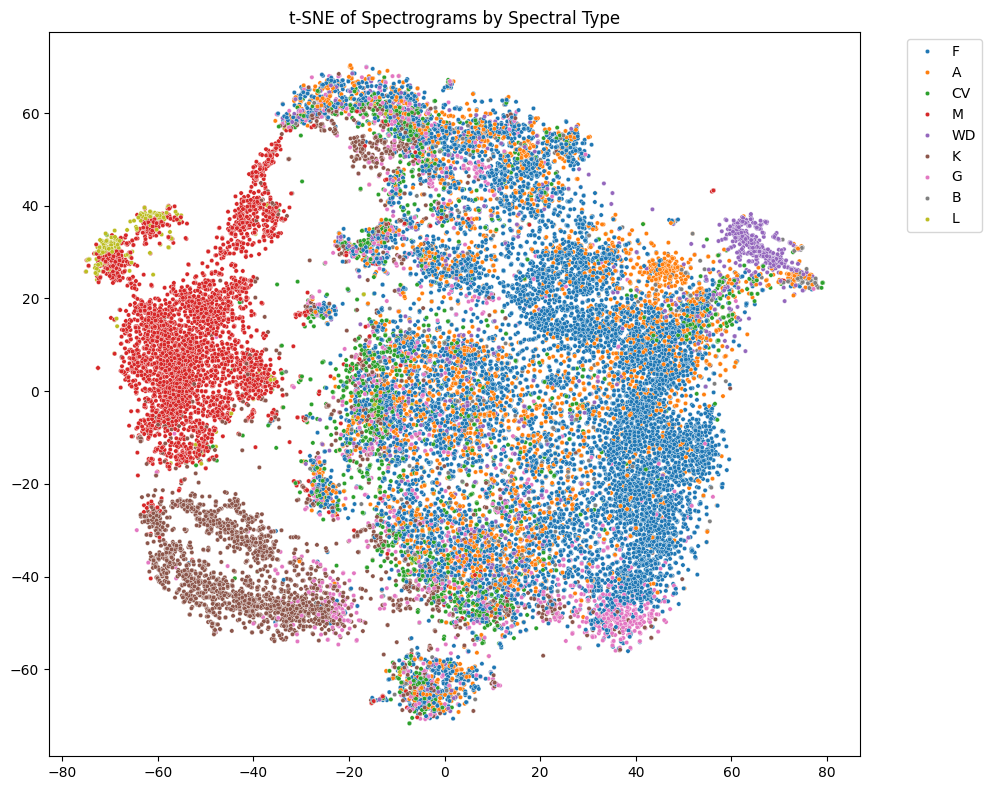

In [22]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(tsne_arr)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=valid_labels, palette="tab10", s=10, legend="full")
plt.title("t-SNE of Spectrograms by Spectral Type")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("tsne_plot.png", bbox_inches='tight')
plt.show()

C:\Users\radiant\AppData\Local\Programs\Git\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


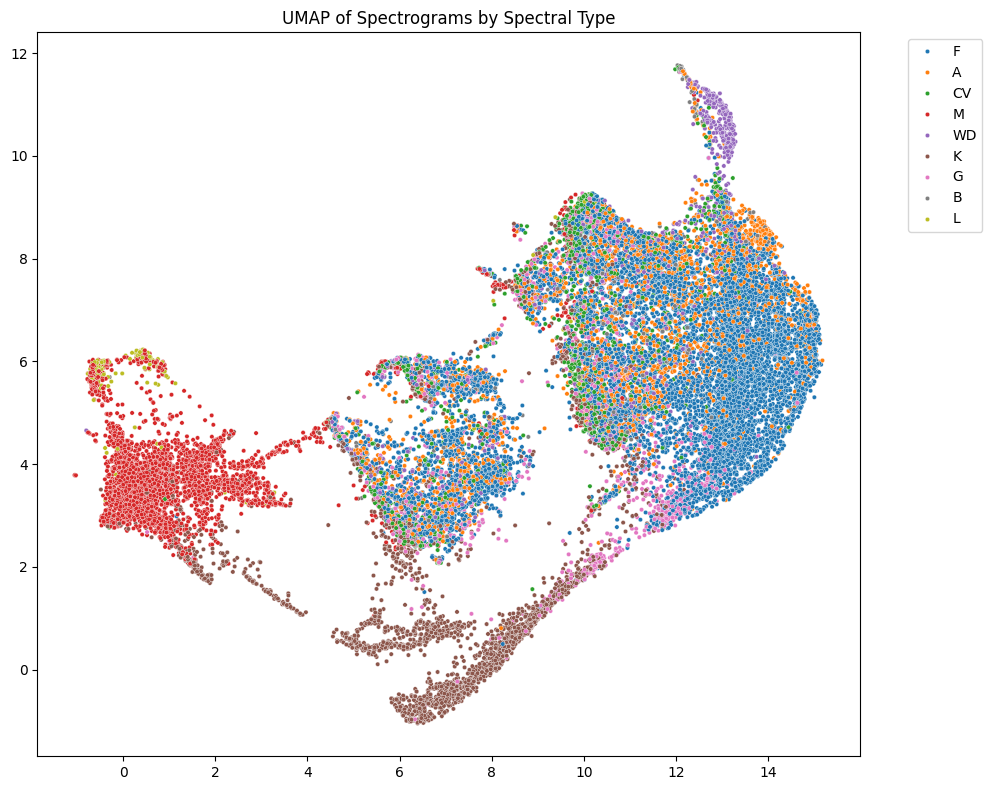

In [24]:
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(tsne_arr)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=valid_labels, palette="tab10", s=10, legend="full")
plt.title("UMAP of Spectrograms by Spectral Type")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("umap_plot.png", bbox_inches='tight')
plt.show()